In [809]:
import sklearn
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import json, csv
import math, re
from scipy import sparse, linalg

In [810]:
example = ["Machine learning is super fun",
"Python is super super cool",
"Statistics is cool too",
"Data science is fun",
"Python is great for machine learning",
"I like football",
"Football is great to watch"]
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(1,1))
dtm = vectorizer.fit_transform(example)
pd.DataFrame(dtm.toarray(),index=example,columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
Machine learning is super fun,0,0,0,1,0,1,0,1,0,0,0,1,0
Python is super super cool,1,0,0,0,0,0,0,0,1,0,0,2,0
Statistics is cool too,1,0,0,0,0,0,0,0,0,0,1,0,0
Data science is fun,0,1,0,1,0,0,0,0,0,1,0,0,0
Python is great for machine learning,0,0,0,0,1,1,0,1,1,0,0,0,0
I like football,0,0,1,0,0,0,1,0,0,0,0,0,0
Football is great to watch,0,0,1,0,1,0,0,0,0,0,0,0,1


In [811]:
def create_dtm_pmi_matrix(dtm_matrix):
    dtm_pmi_matrix = np.zeros(dtm_matrix.shape)
    for i in range(0,dtm_matrix.shape[0]):
        for j in range(0,dtm_matrix.shape[1]):
            dtm_pmi_matrix[i,j] = np.log2(1+(dtm_matrix[i,j]/np.sum(dtm_matrix, axis=0)[j])/(np.sum(dtm_matrix, axis=1)[i]/np.sum(dtm_matrix)))
    return dtm_pmi_matrix

In [812]:
def create_cooccurrence_matrix(filename, dictionary):
    vocabulary={token: pos for pos, token in enumerate(dictionary)}
    data=[]
    row=[]
    col=[]
    for sentence in filename:
        sentence=sentence.lower()
        sentence=sentence.split()
        tokens=[token for token in sentence if token!=u"" and token in list(dictionary.keys())]
        for pos,token in enumerate(tokens):
            i=vocabulary.setdefault(token,len(vocabulary))
            start=0
            end=len(tokens)
            for pos2 in range(start,end,1):
                if pos2==pos: 
                    continue
                j=vocabulary.setdefault(tokens[pos2],len(vocabulary))
                data.append(1.); row.append(i); col.append(j);
    cooccurrence_matrix=sparse.coo_matrix((data,(row,col)))
    return cooccurrence_matrix

In [813]:
M = create_cooccurrence_matrix(example, {name: list([]) for name  in vectorizer.get_feature_names()})

In [814]:
pd.DataFrame(M.toarray(),index=vectorizer.get_feature_names(),columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
cool,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0
data,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
football,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
fun,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
great,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
learning,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
like,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
machine,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
python,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
science,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [815]:
coo_pmi_matrix = create_dtm_pmi_matrix(M.toarray())

In [816]:
pd.DataFrame(coo_pmi_matrix,index=vectorizer.get_feature_names(),columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
cool,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.662965,0.000000,3.807355,1.959358,0.000000
data,0.000000,0.000000,0.000000,2.632268,0.000000,0.000000,0.000000,0.000000,0.000000,3.807355,0.000000,0.000000,0.000000
football,0.000000,0.000000,0.000000,0.000000,2.159199,0.000000,4.196397,0.000000,0.000000,0.000000,0.000000,0.000000,3.273018
fun,0.000000,2.632268,0.000000,0.000000,0.000000,1.450661,0.000000,1.450661,0.000000,2.632268,0.000000,1.108060,0.000000
great,0.000000,0.000000,2.159199,0.000000,0.000000,1.450661,0.000000,1.450661,1.450661,0.000000,0.000000,0.000000,2.632268
learning,0.000000,0.000000,0.000000,1.450661,1.450661,0.000000,0.000000,1.959358,1.289507,0.000000,0.000000,0.973033,0.000000
like,0.000000,0.000000,4.196397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
machine,0.000000,0.000000,0.000000,1.450661,1.450661,1.959358,0.000000,0.000000,1.289507,0.000000,0.000000,0.973033,0.000000
python,1.662965,0.000000,0.000000,0.000000,1.450661,1.289507,0.000000,1.289507,0.000000,0.000000,0.000000,1.548893,0.000000
science,0.000000,3.807355,0.000000,2.632268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [817]:
dtm_pmi_matrix = create_dtm_pmi_matrix(dtm.toarray().T).T

In [818]:
pd.DataFrame(dtm_pmi_matrix,index=example,columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
Machine learning is super fun,0.000000,0.000000,0.000000,1.906891,0.000000,1.906891,0.000000,1.906891,0.000000,0.000000,0.000000,1.502500,0.000000
Python is super super cool,1.906891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.906891,0.000000,0.000000,2.222392,0.000000
Statistics is cool too,2.700440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.584963,0.000000,0.000000
Data science is fun,0.000000,3.058894,0.000000,2.222392,0.000000,0.000000,0.000000,0.000000,0.000000,3.058894,0.000000,0.000000,0.000000
Python is great for machine learning,0.000000,0.000000,0.000000,0.000000,1.906891,1.906891,0.000000,1.906891,1.906891,0.000000,0.000000,0.000000,0.000000
I like football,0.000000,0.000000,2.700440,0.000000,0.000000,0.000000,3.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Football is great to watch,0.000000,0.000000,2.222392,0.000000,2.222392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.058894


In [819]:
etm = np.array(dtm.toarray(), dtype='d')

In [820]:
ETM  = dtm_pmi_matrix @ M

In [821]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = NMF(2,beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=2, l1_ratio=1)
dtm_lsa = lsa.fit_transform(ETM)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [822]:
pd.DataFrame(lsa.components_,index = ["component_1","component_2"],columns = vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
component_1,1.147437,0.301263,6.883859e-08,1.229655,0.823340,1.769663,5.530812e-40,1.769663,1.863139,0.301263,0.211198,2.921749,0.000005
component_2,0.000000,0.000000,1.613581e+00,0.000000,1.603457,0.485164,6.611069e-01,0.485164,0.000000,0.000000,0.000000,0.000000,1.327690


In [823]:
components = np.transpose(lsa.components_)
#components = sklearn.preprocessing.normalize(components, axis=1, norm='l2')

In [824]:
Vxs = [w[0] for w in components]
Vys = [w[1] for w in components]
Vxs, Vys

([1.1474374442991098,
  0.30126323002851,
  6.883858990893855e-08,
  1.22965460498033,
  0.8233399944646232,
  1.7696633560012138,
  5.530811895333936e-40,
  1.7696633560012138,
  1.8631393770025724,
  0.30126323002851,
  0.21119758571853958,
  2.9217486409692293,
  4.978754972438542e-06],
 [0.0,
  0.0,
  1.6135806171918659,
  0.0,
  1.6034572324588932,
  0.4851643393577047,
  0.6611069424187861,
  0.4851643393577047,
  0.0,
  0.0,
  0.0,
  0.0,
  1.3276896690613273])

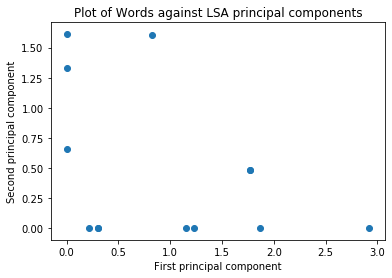

In [825]:
plt.figure()
plt.scatter(Vxs,Vys)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Words against LSA principal components')
plt.show()

Populating the interactive namespace from numpy and matplotlib


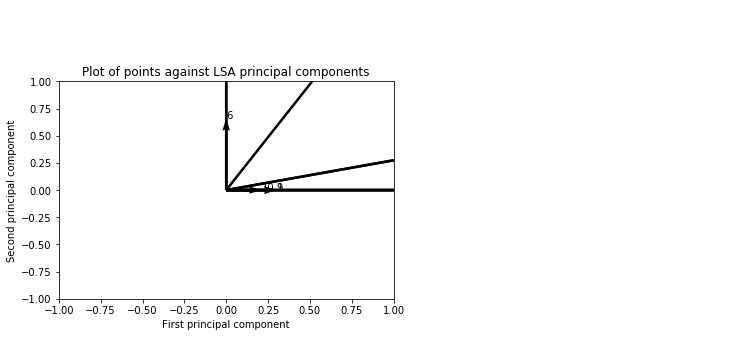

[(0, 'cool'), (1, 'data'), (2, 'football'), (3, 'fun'), (4, 'great'), (5, 'learning'), (6, 'like'), (7, 'machine'), (8, 'python'), (9, 'science'), (10, 'statistics'), (11, 'super'), (12, 'watch')]


In [826]:
%pylab inline
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(Vxs, Vys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01, norm=True)
    ax.annotate('{}'.format(pos),xy=(vec[0], vec[1]),xytext=(vec[0], vec[1]))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(vectorizer.get_feature_names())))

In [827]:
#Compute vectors similarity using LSA components
Vsimilarity = np.asarray(numpy.asmatrix(components) * numpy.asmatrix(components).T)
pd.DataFrame(Vsimilarity,index=vectorizer.get_feature_names(), columns=vectorizer.get_feature_names())

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
cool,1.316613e+00,3.456807e-01,7.898798e-08,1.410952e+00,0.944731,2.030578,6.346261e-40,2.030578,2.137836e+00,3.456807e-01,2.423360e-01,3.352524e+00,0.000006
data,3.456807e-01,9.075953e-02,2.073854e-08,3.704497e-01,0.248042,0.533134,1.666230e-40,0.533134,5.612954e-01,9.075953e-02,6.362607e-02,8.802154e-01,0.000001
football,7.898798e-08,2.073854e-08,2.603642e+00,8.464769e-08,2.587308,0.782852,1.066749e+00,0.782852,1.282559e-07,2.073854e-08,1.453854e-08,2.011291e-07,2.142334
fun,1.410952e+00,3.704497e-01,8.464769e-08,1.512050e+00,1.012424,2.176075,6.800988e-40,2.176075,2.291018e+00,3.704497e-01,2.597001e-01,3.592742e+00,0.000006
great,9.447311e-01,2.480421e-01,2.587308e+00,1.012424e+00,3.248964,2.234975,1.060057e+00,2.234975,1.533997e+00,2.480421e-01,1.738874e-01,2.405593e+00,2.128898
learning,2.030578e+00,5.331345e-01,7.828519e-01,2.176075e+00,2.234975,3.367093,3.207455e-01,3.367093,3.297129e+00,5.331345e-01,3.737486e-01,5.170512e+00,0.644156
like,6.346261e-40,1.666230e-40,1.066749e+00,6.800988e-40,1.060057,0.320746,4.370624e-01,0.320746,1.030467e-39,1.666230e-40,1.168094e-40,1.615964e-39,0.877745
machine,2.030578e+00,5.331345e-01,7.828519e-01,2.176075e+00,2.234975,3.367093,3.207455e-01,3.367093,3.297129e+00,5.331345e-01,3.737486e-01,5.170512e+00,0.644156
python,2.137836e+00,5.612954e-01,1.282559e-07,2.291018e+00,1.533997,3.297129,1.030467e-39,3.297129,3.471288e+00,5.612954e-01,3.934905e-01,5.443625e+00,0.000009
science,3.456807e-01,9.075953e-02,2.073854e-08,3.704497e-01,0.248042,0.533134,1.666230e-40,0.533134,5.612954e-01,9.075953e-02,6.362607e-02,8.802154e-01,0.000001


In [828]:
pd.DataFrame(dtm_lsa, index = example, columns = ["component_" + str(i) for i in range(1,lsa.n_components_+1,1)])

,component_1,component_2
Machine learning is super fun,1.000000e+00,0.000000
Python is super super cool,1.000000e+00,0.000000
Statistics is cool too,1.000000e+00,0.000000
Data science is fun,1.000000e+00,0.000000
Python is great for machine learning,9.009004e-01,0.434026
I like football,4.190670e-21,1.000000
Football is great to watch,7.668443e-02,0.997055


In [829]:
xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
xs, ys

([1.0,
  1.0,
  1.0,
  1.0,
  0.9009004236843207,
  4.19066976996137e-21,
  0.0766844282975156],
 [0.0, 0.0, 0.0, 0.0, 0.43402583633398095, 1.0, 0.9970554139347938])

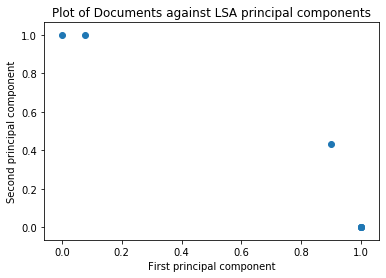

In [830]:
plt.figure()
plt.scatter(xs,ys)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of Documents against LSA principal components')
plt.show()

Populating the interactive namespace from numpy and matplotlib


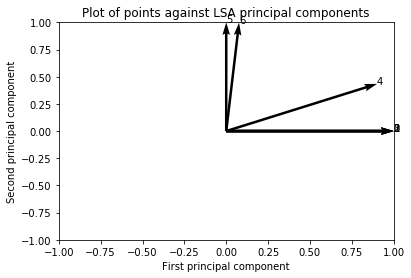

[(0, 'Machine learning is super fun'), (1, 'Python is super super cool'), (2, 'Statistics is cool too'), (3, 'Data science is fun'), (4, 'Python is great for machine learning'), (5, 'I like football'), (6, 'Football is great to watch')]


In [831]:
%pylab inline
plt.figure()
ax = plt.gca()
for pos, vec in enumerate(list(zip(xs, ys))[:]):
    ax.quiver(0,0,vec[0],vec[1],angles='xy',scale_units='xy',scale=1, linewidth = .01)
    ax.annotate('{}'.format(pos),xy=(vec[0], vec[1]),xytext=(vec[0], vec[1]))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Plot of points against LSA principal components')
plt.draw()
plt.show()
print(list(enumerate(example)))

In [832]:
#Compute document similarity using LSA components
similarity = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
pd.DataFrame(similarity,index=example, columns=example)

,Machine learning is super fun,Python is super super cool,Statistics is cool too,Data science is fun,Python is great for machine learning,I like football,Football is great to watch
Machine learning is super fun,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.900900,4.190670e-21,0.076684
Python is super super cool,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.900900,4.190670e-21,0.076684
Statistics is cool too,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.900900,4.190670e-21,0.076684
Data science is fun,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.900900,4.190670e-21,0.076684
Python is great for machine learning,9.009004e-01,9.009004e-01,9.009004e-01,9.009004e-01,1.000000,4.340258e-01,0.501833
I like football,4.190670e-21,4.190670e-21,4.190670e-21,4.190670e-21,0.434026,1.000000e+00,0.997055
Football is great to watch,7.668443e-02,7.668443e-02,7.668443e-02,7.668443e-02,0.501833,9.970554e-01,1.000000
